# Kernel-based Moving Object Detection (KBMOD) Demonstration
**GitHub: http://github.com/dirac-institute/kbmod**

In this notebook, we demonstrate how our shift-and-stack program KBMOD can search a set of images for a trans-Neptunian object (TNO) that is too faint to detect confidently in any one image. 
These images were acquired with the Vera C. Rubin Observatory Commissioning Camera (ComCam) as part of the Science Validation process. 
We made use of the SkyBot service to determine which solar system objects were in the ComCam data. We identified a single TNO, 2013 TA228, which we targeted to test our generalized LSST KBMOD search approach.

Note: The data are currently under embargo, so image data will not be included here; however, images will be shown during the live demo. 

### Initial Setup

In [1]:
show_embargoed = False  # show pixel data currently under Rubin embargo

In [2]:
# Load general libraries needed
from astropy.time import Time
from astropy.wcs import WCS
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.table import Table
from astropy.table import conf
import astropy.units as u

import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

import glob

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress GPU logging

# Import the needed KBMOD components
import kbmod
from kbmod.configuration import SearchConfiguration
import kbmod.reprojection as reprojection
from kbmod.reprojection_utils import correct_parallax_geometrically_vectorized
from kbmod.filters.known_object_filters import KnownObjsMatcher
from kbmod.filters.stamp_filters import filter_stamps_by_cnn
from kbmod.results import Results
from kbmod.analysis.plotting import *
from kbmod.analysis.plotting import plot_ic_image_bounds, plot_wcs_on_sky
from kbmod.analysis.visualizer import Visualizer

# Import the LSST Butler interface for accessing ComCam data
import lsst.daf.butler as dafButler

In [3]:
# Confirm that a GPU is available and that at least 30 Gb of RAM is available
kbmod.search.validate_gpu(30 * 1024 * 1024 * 1024)

True

In [4]:
# Working directories
basedir = f"rubin-user/lincc_fw_kbmod_demo"  # Root directory for the demo.
workdir = f"{basedir}/20X20_patch250060"  # The subdirectory where images and other input and output files will be located

# The file contains the configuration parameters used for the KBMOD search.
kbmod_config_path = f"{workdir}/search_config_deep_20250122_39au_a.yaml"

# The KBMOD ImageCollection containing Butler-derived metadata.
full_comcam_ic_path = (
    f"{basedir}/LSSTComCam_runs_DRP_20241101_20241211_w_2024_50_DM-48128.collection"
)

# This is an ImageCollection, output by kbmod.ImageCollection
ic_path = f"{workdir}/tno_2013_TA228_ComCam_w50_20x20_patch250060_betterIDs.collection"

# Define the filename of the WorkUnit that combines the metadata from the ImageCollection and the image data from the Butler.
wu_filename = "tno_2013_TA228_ComCam_w50_20x20_patch110571_wu.fits"

# Reprojected (i.e., reflex-corrected) configuration.
repro_shard_dir = os.path.join(
    workdir, "repro"
)  # The directory to store the reprojected WorkUnit.
repro_workunit_filename = wu_filename + ".repro"

# Paths for results filtering and analysis
ml_model_path = f"{basedir}/kbmod_comcam_05.h5"  # the CNN model
skybot_table_path = f"/sdf/home/c/colinc/skytable.csv"  # solar system objects viewable in the ComCam fields found via SkyBot service

# Create any missing directories
for dirname in [basedir, workdir, repro_shard_dir]:
    os.makedirs(dirname, exist_ok=True)

### Exploring the Rubin Solar System Science Validation Field

Here we load a KBMOD ImageCollection, a table of metadata derived (in this case) from a LSST ComCam Butler Collection of difference image data and optimized for efficient analyses.
The goal of this section is to visualize the on-sky availability of image data we can search.

In [5]:
comcam_ic = kbmod.ImageCollection.read(full_comcam_ic_path)
print(
    f'The full ComCam Butler contains {len(set(comcam_ic["visit"]))} science exposures.'
)

The full ComCam Butler contains 1943 science exposures.


### Narrowing down the search area
Rubin observed an area of the sky (labeled "Rubin_SV_38_7") near the plane of the solar system (ecliptic), where we are most likely to find TNOs.

In [6]:
ecliptic_comcam_field = "Rubin_SV_38_7"  # This is the label for the ecliptic field
ecliptic_ic = comcam_ic[comcam_ic["object"] == ecliptic_comcam_field]
print(
    f'There were {len(set(ecliptic_ic["visit"]))} exposures for {ecliptic_comcam_field}.'
)

There were 175 exposures for Rubin_SV_38_7.


Next we visualize the on-sky area covered by the ecliptic ComCam observations.

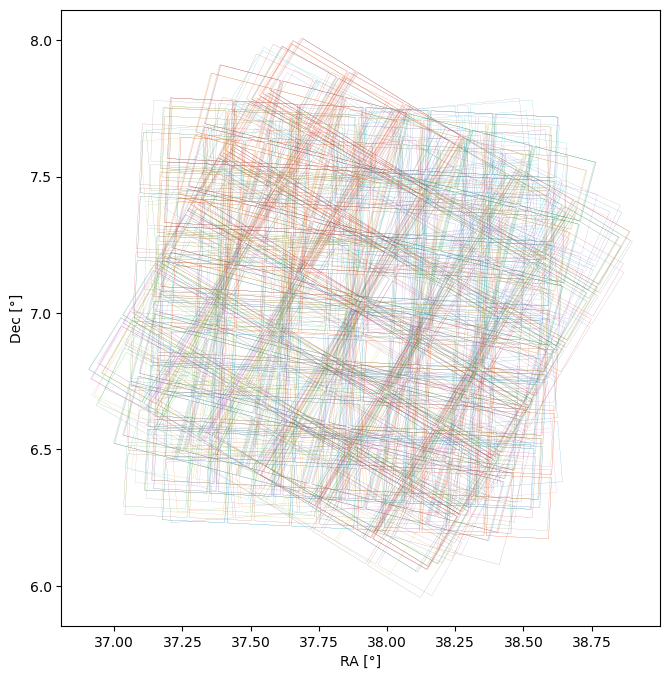

In [7]:
_ = plot_ic_image_bounds(ecliptic_ic, lw=0.1)

### Load the ImageCollection and generate WorkUnit
This ImageCollection is a collection of ComCam image metadata that overlaps with a 20' X 20' patch of the sky as generated by our Region Search toolset. We chose 20' X 20' patches as an optimal size to fit on the available GPU architecture. 
We use the ImageCollection to gather Butler-derived images into a KBMOD WorkUnit. 
Note that (at present) it takes roughly 4 seconds per image retrieval through the USDF Butler.

In [8]:
# Load the ImageCollection
ic = kbmod.ImageCollection.read(ic_path)
print(f"Read {len(ic)} rows from {ic_path}.")

Read 249 rows from rubin-user/lincc_fw_kbmod_demo/20X20_patch250060/tno_2013_TA228_ComCam_w50_20x20_patch250060_betterIDs.collection.


In [9]:
# Example row from the ImageCollection, trimmed to remove bulky columns (e.g., WCS)
display_ic = ic.data.copy()
display_ic.remove_columns(["wcs", "global_wcs", "config"])
display_ic[0]

dataId,std_idx,visit,detector,band,filter,mjd_start,mjd_mid,object,pointing_ra,pointing_dec,airmass,wcs_err,ra,dec,ra_bl,dec_bl,ra_tl,dec_tl,ra_tr,dec_tr,ra_br,dec_br,psfSigma,psfArea,nPsfStar,zeroPoint,skyBg,skyNoise,meanVar,OBSID,exposureTime,ext_idx,std_name,collection,datasetType,obs_lon,obs_lat,obs_elev,astromOffsetMean,astromOffsetStd,DIMM2SEE,global_wcs_pixel_shape_0,global_wcs_pixel_shape_1
str36,int64,int64,int64,str1,str4,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str20,float64,int64,str18,str56,str28,float64,float64,float64,float64,float64,float64,int64,int64
615b2f69-ba41-4d4b-b29b-a807e7a3ac82,0,2024112600134,8,i,i_06,60641.08122699644,60641.08140639459,Rubin_SV_38_7,38.0653955028628,6.52826805904292,1.28850130948918,-3.090860900556436e-12,38.18728959931873,6.2575399328953285,38.13367905883207,6.407125257662862,38.03592432637463,6.206883852393906,38.24092893534934,6.107783069946998,38.33871170185693,6.30809586582424,2.1870157927318044,67.46518367993608,102,31.76327910494223,2581.0746131539345,52.993192583897475,2795.876509900088,CC_O_20241126_000134,30.0,0,ButlerStandardizer,LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128,goodSeeingDiff_differenceExp,-70.7494170285165,-30.2446389756252,2662.99616375123,nan,nan,0.0,6000,6000


In [10]:
%%time

wu = ic.toWorkUnit(
    search_config=SearchConfiguration.from_file(kbmod_config_path),
    butler=dafButler.Butler("/repo/embargo"),
)
wu.to_sharded_fits(wu_filename, workdir, overwrite=True)  # save the WorkUnit to disk
print(
    f"WorkUnit {wu_filename} contains {len(wu)} images, spanning {len(set(wu.get_all_obstimes()))} unique timestamps."
)

WorkUnit tno_2013_TA228_ComCam_w50_20x20_patch110571_wu.fits contains 249 images, spanning 57 unique timestamps.
CPU times: user 20min 2s, sys: 2min 33s, total: 22min 36s
Wall time: 28min 58s


### Inspect ComCam images from the first exposure in the WorkUnit
Now that we have materialized our WorkUnit, we can access the data efficiently.
Note the artifacts present in the image data example shown here.

In [11]:
first_visit_slices = wu.get_unique_obstimes_and_indices()[1][0]
first_wu_visit = wu.get_constituent_meta("visit")[0]

if show_embargoed:
    for visit_slice in first_visit_slices:
        im = wu.im_stack.get_single_image(visit_slice).get_science().image
        vmin, vmax = np.percentile(im, [1, 99])
        plt.imshow(im, cmap="gray", vmin=vmin, vmax=vmax)
        plt.colorbar(label="Pixel Value")
        plt.show()
        plt.close()
        break

### Create reflex-corrected WCS for each image
Create new world coordinate system (WCS) elements for each image in the WorkUnit, correcting for the parallax imparted by Earth's motion around the Sun for (as yet undiscovered) objects at 39 au.

In [12]:
# This is the target search distance in astronomical units for our reflex-correction and reprojection routines
target_search_dist = 39.0  # au

In [13]:
%%time

# Find the estimated barycentric distance (EBD) world coordinate system (WCS) for each image
ebd_per_image_wcs, geocentric_dists = kbmod.reprojection_utils.transform_wcses_to_ebd(
    [wu.get_wcs(i) for i in range(len(wu))],
    height=wu.get_wcs(0).array_shape[0],
    width=wu.get_wcs(0).array_shape[1],
    heliocentric_distance=target_search_dist,  # heliocentric reflex correction distance in au
    obstimes=Time(wu.get_all_obstimes(), format="mjd"),
    point_on_earth=EarthLocation.of_site("Rubin Observatory"),
    npoints=10,
)

# Store reflex-corrected WCSs and metadata in the WorkUnit.
wu.org_img_meta["ebd_wcs"] = ebd_per_image_wcs
wu.heliocentric_distance = target_search_dist
wu.org_img_meta["geocentric_distance"] = geocentric_dists

CPU times: user 38.6 s, sys: 715 ms, total: 39.3 s
Wall time: 40.5 s


### Reprojecting images to common WCS
Here, we create mosaics from the input images and handle arbitrary image rotation. We built these features upon the extant AstroPy Reproject functionality.

In [14]:
%%time
common_wcs = WCS(ic.data["global_wcs"][0])
common_wcs.pixel_shape = (
    ic.data["global_wcs_pixel_shape_0"][0],
    ic.data["global_wcs_pixel_shape_1"][0],
)

reprojected_wu = reprojection.reproject_work_unit(
    wu,
    common_wcs,
    parallelize=True,
    frame="ebd",
    max_parallel_processes=16,
)
reprojected_wu.to_sharded_fits(repro_workunit_filename, repro_shard_dir, overwrite=True)

Reprojecting: 100%|██████████| 57/57 [42:41]


CPU times: user 29.4 s, sys: 2min 20s, total: 2min 50s
Wall time: 43min 46s


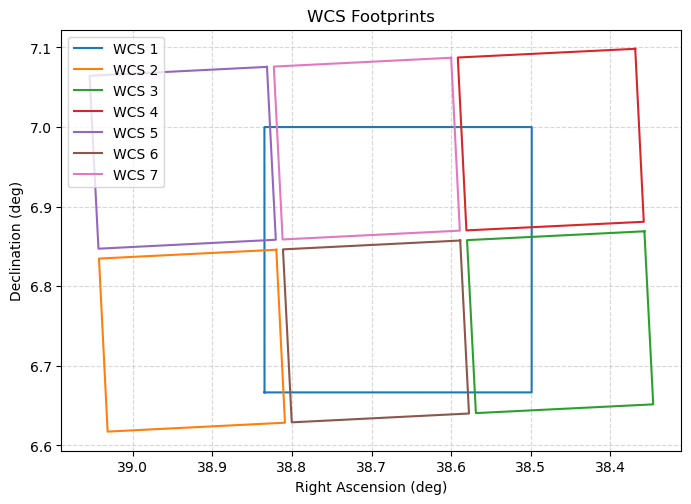

In [15]:
desired_slice = 0
chip_WCSs = []

for slice in wu.get_unique_obstimes_and_indices()[1][desired_slice]:
    chip_WCSs.append(ebd_per_image_wcs[slice])

if show_embargoed:
    im = reprojected_wu.im_stack.get_single_image(desired_slice).get_science().image
    vmin, vmax = np.percentile(im, [1, 99])
    plt.imshow(im, cmap="gray", vmin=vmin, vmax=vmax, origin="lower")
    plt.colorbar(label="Pixel Value")

_ = plot_wcs_on_sky([reprojected_wu.get_wcs(desired_slice)] + chip_WCSs)

### Run the KBMOD search

Here we configure and execute a broad KBMOD search that reflects our general strategy for discovering distant solar system objects in LSST data.

In [16]:
# First, modify and update the KBMOD configuration based on the .yaml file.
config = kbmod.configuration.SearchConfiguration.from_file(kbmod_config_path)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
resultsdir = f"{workdir}/results_{timestamp}"
os.makedirs(resultsdir, exist_ok=True)

full_results_path = os.path.join(resultsdir, "full_results.ecsv")

settings = {
    "generator_config": {
        "name": "EclipticCenteredSearch",  # perform our search in relation to the plane of the solar system
        "velocities": [
            25,  # minimum velocity, in the units specified by velocity_units below
            225,  # maximum velocity, in the units specified by velocity_units below
            64,  # number of steps spanning the velocity search range
        ],
        "velocity_units": "pix / d",
        "angles": [
            90,  # minimum search angle w.r.t. the ecliptic, in the units specified by angle_units below
            -90,  # maximum search angle w.r.t. the ecliptic, in the units specified by angle_units below
            64,  # number of steps spanning the angle space to search
        ],
        "angle_units": "degree",
    },
    "result_filename": full_results_path,  # path to .ecsv results file
    "res_filepath": resultsdir,  # the directory to output any additional results
}
config.set_multiple(settings)

reprojected_wu.config = config

config.to_file(
    os.path.join(resultsdir, "search_config.yaml")
)  # save the configuration yaml for provenance

In [17]:
%%time

res = kbmod.run_search.SearchRunner().run_search_from_work_unit(reprojected_wu)
res.write_table(full_results_path)

print(
    f"Found {len(res)} results spanning {len(reprojected_wu)} unique timestamps/images."
)

Found 157 results spanning 57 unique timestamps/images.
CPU times: user 31min 12s, sys: 5min 18s, total: 36min 30s
Wall time: 30min 55s


### KBMOD-ML filtering of results with a prototype CNN

We are looking for very faint objects at a very low signal-to-noise ratio, and, consequently, many false positives are produced during the search phase. 
Here we employ a simple network trained on a limited set of ComCam data to filter out images unlikely to show a real minor planet.

Each row of the results table represents a trajectory, its associated likelihood, and provenance metadata.

In [18]:
%%time

filter_stamps_by_cnn(
    res,
    ml_model_path,
    coadd_type="mean",
)

res.filter_rows(res["cnn_class"])

CPU times: user 1.84 s, sys: 1.96 s, total: 3.8 s
Wall time: 9.76 s


x,y,vx,vy,likelihood,flux,obs_count,psi_curve,phi_curve,obs_valid,stamp,coadd_sum,coadd_mean,coadd_median,coadd_weighted,pred_x,pred_y,global_ra,global_dec,img_ra,img_dec,img_x,img_y,cnn_class
int64,int64,float64,float64,float64,float64,int64,float64[57],float64[57],bool[57],"float32[21,21]","float32[21,21]","float32[21,21]","float32[21,21]","float32[21,21]",float64[57],float64[57],float64[57],float64[57],float64[57],float64[57],float64[57],float64[57],bool
5806,4356,56.43665313720703,204.66281127929688,36.18541069178031,408.0334010176237,13,0.021866656839847565 .. 0.0,0.0007294111419469118 .. 0.0,True .. False,20.23334 .. -94.70616,20.23334 .. -94.70616,0.20920493 .. -11.737687,-0.892758 .. -15.635595,0.4706418 .. -13.5011215,5806.5 .. 6595.212314990027,4356.5 .. 7216.699368733327,38.509554174106526 .. 38.46534989502967,6.908724233093626 .. 7.0676054724718105,37.99950777072311 .. 37.65020753113546,6.548096974723788 .. 6.637261099587939,-3265.7342346515434 .. -4678.760098605894,-1234.9678896386515 .. -3509.434930227521,True
5699,4540,-90.18154907226562,-202.6667022705078,21.636266696267654,139.48144378247687,28,0.0 .. 0.0,0.0 .. 0.0,False .. False,-3.855865 .. 159.08072,-3.855865 .. 159.08072,-0.1676726 .. 5.853974,-0.2045532 .. 2.0483239,-0.34978858 .. 5.0418344,5699.5 .. 4439.196732808537,4540.5 .. 1708.1966114458473,38.51553881689849 .. 38.58609544699804,6.918948322922115 .. 6.761615447790551,38.00561554046287 .. 37.77376536820506,6.558564834967566 .. 6.325401982056455,-3249.8332376762755 .. -2203.885892032664,-1452.0794408411098 .. 1981.7598218750734,True
1949,5209,-17.98046875,224.28041076660156,21.454490490696276,352.73717113297073,8,0.20420870184898376 .. 0.0,0.0006917000864632428 .. 0.0,True .. False,0.77013946 .. -29.16818,0.77013946 .. -29.16818,-0.100083984 .. -3.322124,0.11093342 .. -2.8502007,1.5113386 .. -2.1484447,1949.5 .. 1698.2197354183827,5209.5 .. 8343.85882798692,38.72540442743863 .. 38.739494440757106,6.956135081307372 .. 7.130261575762976,38.22015755804006 .. 37.92941275832548,6.596832843939637 .. 6.701618950071004,-101.53375772224335 .. 237.1118383536974,-3745.320939526413 .. -4907.2114066174245,True
958,5536,-157.93850708007812,160.2511444091797,21.34441288926638,1402.2396725884832,8,0.11928845942020416 .. 0.0,5.621158197754994e-05 .. 0.0,True .. False,-63.087055 .. -18.010695,-63.087055 .. -18.010695,-8.205102 .. -1.4904785,-4.993581 .. -0.01013577,-5.1580286 .. -3.1463404,958.5 .. -1248.7188661214773,5536.5 .. 7776.038386152787,38.78087232587586 .. 38.90446999700032,6.974291552722317 .. 7.098661938523675,38.27685358452782 .. 38.097567883544286,6.615469142981776 .. 6.669664016320991,662.8313851602777 .. 3263.145364664731,-4489.756106036503 .. -4481.656509372213,True
5919,2932,-143.79998779296875,119.39411163330078,16.20137890938901,99.0629908946779,38,0.015175960026681423 .. 0.009721929207444191,0.0004723590100184083 .. 0.0004808444937225431,True .. True,-3.399155 .. -0.8875536,-3.399155 .. -0.8875536,-0.09186905 .. 0.21398003,-0.5983776 .. -1.1679907,-2.7276354 .. -0.015119868,5919.5 .. 3909.8694680123112,2932.5 .. 4601.054050388868,38.50325757649764 .. 38.615691293298,6.829611374939618 .. 6.922333551456416,37.993156529452705 .. 37.80364087396999,6.46713967359623 .. 6.489354554698109,-2731.2927110080623 .. -1816.8844973030682,125.06629170645658 .. -985.4264162302392,True
5903,1394,-33.183048248291016,-42.05690383911133,12.383961779984718,96.89468373950923,28,0.0011428374564275146 .. 0.0,0.0007491682772524655 .. 0.0,True .. False,-60.04982 .. 6.2468038,-60.04982 .. 6.2468038,-1.9789535 .. -0.057001058,-2.1704392 .. -0.34152177,-4.062559 .. 0.06314609,5903.5 .. 5439.760969644903,1394.5 .. 806.7472516643635,38.50418184716348 .. 38.530133755347784,6.744167646762159 .. 6.711522815700898,37.99419410776594 .. 37.71683460166332,6.379712676217073 .. 6.274229064564032,-2027.6290900309648 .. -3172.339575868223,1531.4937546277333 .. 2947.7501223352206,True
5713,2654,-102.30045318603516,175.0812530517578,14.35434

### Visualize Results
Here we visualize results in the form of co-added image cutouts. For each row in the results table, we (1) generate a combined co-added image cutout that spans all results above the prescribed likelihood threshold, and (2) provide daily co-added cutouts. 

In [19]:
if show_embargoed:
    res.table["stamp"] = res.table[
        "coadd_sum"
    ]  # We store the combined stamps in the results table.
    viz = Visualizer(
        reprojected_wu.im_stack, res
    )  # The image data are derived from the reprojected WorkUnit.
    viz.generate_all_stamps(radius=config["stamp_radius"])
    viz.count_num_days()  # This feature enables the daily image co-addition.

    for res_idx in range(10):  # first 10 results
        viz.plot_daily_coadds(res_idx)

### Matching to known objects
For testing and validation in Rubin data we will make use of known small solar system bodies (e.g., TNOs) we previously identified in ComCam data with SkyBot. In the future we will make use of Rubin's MPCSky routine to greatly optimize this process.

In [20]:
skytable = Table.read(skybot_table_path)
print(f"Read {skybot_table_path}. There are {len(skytable)} rows.")

Read /sdf/home/c/colinc/skytable.csv. There are 9544 rows.


In [21]:
known_objs_matcher = KnownObjsMatcher(
    skytable,
    np.array(reprojected_wu.get_all_obstimes()),
    matcher_name="known_matcher",
    sep_thresh=5.0,  # Observations must be within 5 arcsecs.
    time_thresh_s=30,  # Observations must match within 30 seconds.
    name_col="Name",
    ra_col=f"ra_{target_search_dist}",
    dec_col=f"dec_{target_search_dist}",
    mjd_col="mjd_mid",
)

# Carry out initial matching to known objects and populate the matches column.
known_objs_matcher.match(res, reprojected_wu.wcs)

# Filter the matches down to results with at least 10 observations.
min_obs = 10
known_objs_matcher.match_on_min_obs(res, min_obs)

matched_col_name = known_objs_matcher.match_min_obs_col(min_obs)

known_tno_results = []
for res_idx in range(len(res)):
    my_matches = res[res_idx][matched_col_name]
    if len(my_matches) >= 1:
        print(f"Result {res_idx} matched to objects: {my_matches}")
        if "2013 TA228" in my_matches:
            known_tno_results.append(res_idx)
        if show_embargoed:
            viz.plot_daily_coadds(res_idx)

Result 14 matched to objects: {'2013 TA228'}


Here we plot our KBMOD TNO trajectory against the cached SkyBot ephemeris results.

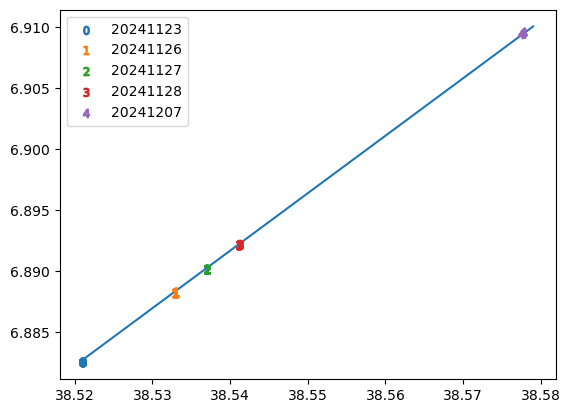

In [22]:
tnotable = skytable[skytable["Name"] == "2013 TA228"]
tnotable.sort("mjd_mid")

tno_res_idx = known_tno_results[0]

plt.plot(res[tno_res_idx]["global_ra"], res[tno_res_idx]["global_dec"], zorder=1)
for i, day_obs in enumerate(set(tnotable["day_obs"])):
    tno_day_table = tnotable[tnotable["day_obs"] == day_obs]
    plt.scatter(
        tno_day_table[f"ra_{target_search_dist}"],
        tno_day_table[f"dec_{target_search_dist}"],
        label=f"{day_obs}",
        marker=f"${i}$",
    )
_ = plt.legend()

### Refine candidate trajectory with pencil search
Here we carry out a search for the TNO using a finer grid of candidate velocities derived from the initial KBMOD search. We use the KBMOD VelocityGridSearch method, which operates in pixel space instead of searching for angles centered around the ecliptic.

In [23]:
%%time

# First, modify and update the KBMOD configuration for the pencil search.
resultsdir = f"{workdir}/results_pencil_{timestamp}"
os.makedirs(resultsdir, exist_ok=True)

full_results_path = os.path.join(resultsdir, "full_results.ecsv")

settings = {
    "generator_config": {
        "name": "VelocityGridSearch",  # perform our search in relation to pixel/velocity space.
        "min_vx": int(res[tno_res_idx]["vx"]) - 2,
        "max_vx": int(res[tno_res_idx]["vx"]) + 2,
        "min_vy": int(res[tno_res_idx]["vy"]) - 2,
        "max_vy": int(res[tno_res_idx]["vy"]) + 2,
        "vx_steps": 20,
        "vy_steps": 20,
    },
    "result_filename": full_results_path,  # path to .ecsv results file
    "res_filepath": resultsdir,  # the directory to output any additional results
}
config.set_multiple(settings)

reprojected_wu.config = config

config.to_file(
    os.path.join(resultsdir, "search_config.yaml")
)  # save the configuration yaml for provenance

pencil_res = kbmod.run_search.SearchRunner().run_search_from_work_unit(reprojected_wu)

print(
    f"Found {len(pencil_res)} results from the pencil search for initial result {tno_res_idx}."
)

Found 22 results from the pencil search for initial result 14.
CPU times: user 1min 59s, sys: 29.4 s, total: 2min 29s
Wall time: 1min 45s


### Matching against known objects to recover the TNO
Once again we match the search results against known objects, this time with the output from the pencil search.
We then display the combined co-added images and daily cutouts for both the updated search result with the initial result to facilitate comparison. The results from the pencil search (result 9 below) indicate a better match to the object's actual trajectory with the object appearing closer to the center of each cutout.

In [24]:
# Carry out initial matching to known objects and populate the matches column.
known_objs_matcher.match(pencil_res, reprojected_wu.wcs)
known_objs_matcher.match_on_min_obs(pencil_res, min_obs)

# Instantiate a KBMOD Vizualizer for the pencil search.
pencil_res.table["stamp"] = pencil_res.table[
    "coadd_sum"
]  # Store combined stamps in the results table.
pencil_viz = Visualizer(
    reprojected_wu.im_stack, pencil_res
)  # Image data are derived from the reprojected WorkUnit.
pencil_viz.generate_all_stamps(radius=config["stamp_radius"])
pencil_viz.count_num_days()  # Enable the daily image co-addition.

# Show the cutouts from our pencil search.
for res_idx in range(len(pencil_res)):
    my_matches = pencil_res[res_idx][matched_col_name]
    if len(my_matches) >= 1:
        print(f"Result {res_idx} matched to objects: {my_matches}")
        if show_embargoed:
            pencil_viz.plot_daily_coadds(res_idx)

# Display the initial known TNO result from the earlier search for comparison.
if show_embargoed:
    viz.plot_daily_coadds(tno_res_idx)

Result 11 matched to objects: {'2013 TA228'}


### Next Steps

We next send results for orbit fitting; the upcoming selected incubator will help automate and optimize this process.

### Summary & Key Takeaways
- KBMOD represents a novel way of working with Rubin images.
- KBMOD will lead to software facilitating scalable image science.
- Unique in LINCC Frameworks, KBMOD directly produces discoveries.
- Our work has demonstrated how KBMOD facilitates probing two magnitudes fainter.
  - This effectively transforms the 6.7 m Rubin into a 16 m telescope in terms of TNO discovery.
  - This will enhance the LSST discovery of TNOs by a factor of about 5X.
- KBMOD has proven success with multiple surveys (e.g., DEEP, KLASSI).
- KBMOD works with Rubin ComCam and ready for LSSTCam.
  - New: spanning multiple nights, filters, and rotation angles
  - We successfully recovered one TNO (as shown in this notebook) and one Jupiter Trojan in ComCam data.
- KBMOD is capable of LSST-scale deployment.
